In [1]:
# Import Libraries
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Import Data (Insert your path here)
path = '/Users/las/Documents/GitHub/REU/data_v1.csv'
df = pd.read_csv(path)

In [3]:
# Create Training and Validation Data
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("no", axis=1).astype('float64'),
    round(df["no"]/2), 
    test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = np.asarray(X_train), np.asarray(X_test), np.asarray(y_train), np.asarray(y_test)

In [4]:
# Set Up Network Architecture
model = keras.Sequential([
    keras.layers.Dense(units=1000, activation='relu', input_shape=(18,)),
    keras.layers.Dense(units=1000, activation='relu'),
    keras.layers.Dense(units=93, activation='softmax')
])

model.summary()

2022-09-30 10:29:19.669954: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-30 10:29:19.676894: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              19000     
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 93)                93093     
Total params: 1,113,093
Trainable params: 1,113,093
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Set up training
sce = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='Adam', loss=sce, metrics=['accuracy', sce])

In [6]:
# Train model
history = model.fit(
    X_train,
    y_train,
    verbose=0,
    epochs=50,
    batch_size=64,
    validation_data=(
        X_test,
        y_test
    )
)

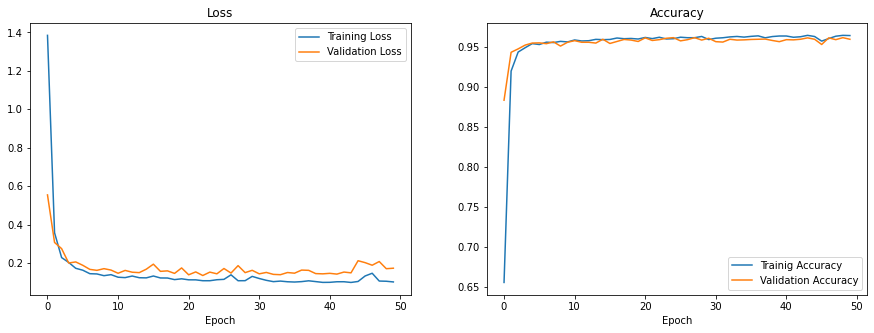

In [7]:
# Graphs
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(history.history['loss'], label="Training Loss") 
axs[0].plot(history.history['val_loss'], label="Validation Loss")
axs[0].set_title("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(history.history['accuracy'], label="Trainig Accuracy") 
axs[1].plot(history.history['val_accuracy'], label="Validation Accuracy")
axs[1].legend(loc="lower right")
axs[1].set_title("Accuracy")
axs[1].sharex(axs[0])

for ax in axs.flat:
    ax.set(xlabel='Epoch')